# Проект "Прогнозирование температуры звезды"

Пришла задача от обсерватории «Небо на ладони»: придумать, как с помощью нейросети определять температуру на поверхности обнаруженных звёзд. Обычно для расчёта температуры учёные пользуются следующими методами:

* Закон смещения Вина.
* Закон Стефана-Больцмана.
* Спектральный анализ.

Каждый из них имеет плюсы и минусы. Обсерватория хочет внедрить технологии машинного обучения для предсказания температуры звёзд, надеясь, что этот метод будет наиболее точным и удобным.
В базе обсерватории есть характеристики уже изученных 240 звёзд.

Характеристики: 

* Относительная светимость L/Lo — светимость звезды относительно Солнца.
* Относительный радиус R/Ro — радиус звезды относительно радиуса Солнца.
* Абсолютная звёздная величина Mv — физическая величина, характеризующая блеск звезды.
* Звёздный цвет (white, red, blue, yellow, yellow-orange и др.) — цвет звезды, который определяют на основе спектрального анализа.
* Тип звезды.
* Абсолютная температура T(K) — температура на поверхности звезды в Кельвинах.

В этом самостоятельном проекте необходимо разработать нейронную сеть, которая поможет предсказывать абсолютную температуру на поверхности звезды.

**Шаг 1. Загрузка исходных данных из файла**
/datasets/6_class.csv 

**Шаг 2. Исследовательский анализ**
Провести исследовательский анализ:
* количественных данных,
* категориальных данных.
Обязательно использовать графический анализ и сделать вывод.

**Шаг 3. Подготовка данных к построению модели**
1) По результату исследовательского анализа внесити корректировки, если они нужны. Сделать вывод.

2) Если необходимо, категоризировать исходные данные.

3) Подготовьить обучающую и тестовую выборки.

4) Провести масштабирование количественных данных.

**Шаг 4. Построение простой модели нейронной сети — baseline**
* Создать класс для задания архитектуры нейронной сети.
* Самостоятельно выберать количество скрытых слоёв, количество нейронов на них, функции активации на скрытых и выходном слоях. * Попробовать и сравнить несколько подобных комбинаций.
* Провести обучение нейронной сети:
* Создайть функцию для обучения нейронной сети.
* Провести обучение модели.
* Построить график «Факт — Прогноз», где по горизонтальной оси будут отложены условные номера звёзд, а по вертикальной — температура в Кельвинах.
* Сделать вывод.

**Шаг 5. Улучшение сети**
* Создайть решение с перебором параметров нейросети. Список параметров для перебора должен включать как минимум «dropout» и «размер батча». Архитектуру нейронной сети: количество слоёв, нейронов, вид функции активации — оставить как в Baseline, чтобы сравнить результат.
* Провести обучение нейронной сети. Вывести метрику RMSE и график «Факт — прогноз». Метрика RMSE не должна превышать 4500.
* Сделать вывод. Желательно оформить его в виде таблицы или графика.

**Шаг 6. Выводы по проекту**
* Кратко описать результаты каждого типа модели.
* Напишить выводы сравнения двух моделей.

## Загрузка данных

In [1]:
!pip install pandas_profiling -q

In [2]:
import pandas as pd
import numpy as np
import os
from tqdm import tqdm
import plotly.express as px
import random
import copy
import pandas_profiling
import matplotlib.pyplot as plt

from math import ceil, sqrt

import torch
import torch.nn as nn

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.model_selection import train_test_split

/tmp/ipykernel_211/4003695607.py:8: DeprecationWarning: `import pandas_profiling` is going to be deprecated by April 1st. Please use `import ydata_profiling` instead.
  import pandas_profiling


In [3]:
df = pd.read_csv('/datasets/6_class.csv', index_col=0)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 240 entries, 0 to 239
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Temperature (K)         240 non-null    int64  
 1   Luminosity(L/Lo)        240 non-null    float64
 2   Radius(R/Ro)            240 non-null    float64
 3   Absolute magnitude(Mv)  240 non-null    float64
 4   Star type               240 non-null    int64  
 5   Star color              240 non-null    object 
dtypes: float64(3), int64(2), object(1)
memory usage: 13.1+ KB


In [5]:
df.describe()

,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type
count,240.000000,240.000000,240.000000,240.000000,240.000000
mean,10497.462500,107188.361635,237.157781,4.382396,2.500000
std,9552.425037,179432.244940,517.155763,10.532512,1.711394
min,1939.000000,0.000080,0.008400,-11.920000,0.000000
25%,3344.250000,0.000865,0.102750,-6.232500,1.000000
50%,5776.000000,0.070500,0.762500,8.313000,2.500000
75%,15055.500000,198050.000000,42.750000,13.697500,4.000000
max,40000.000000,849420.000000,1948.500000,20.060000,5.000000


In [6]:
df.head(10)

,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type,Star color
0,3068,0.002400,0.1700,16.12,0,Red
1,3042,0.000500,0.1542,16.60,0,Red
2,2600,0.000300,0.1020,18.70,0,Red
3,2800,0.000200,0.1600,16.65,0,Red
4,1939,0.000138,0.1030,20.06,0,Red
5,2840,0.000650,0.1100,16.98,0,Red
6,2637,0.000730,0.1270,17.22,0,Red
7,2600,0.000400,0.0960,17.40,0,Red
8,2650,0.000690,0.1100,17.45,0,Red
9,2700,0.000180,0.1300,16.05,0,Red


In [7]:
df.isna().sum()

Temperature (K)           0
Luminosity(L/Lo)          0
Radius(R/Ro)              0
Absolute magnitude(Mv)    0
Star type                 0
Star color                0
dtype: int64

In [8]:
df.duplicated().sum()

0

**Вывод:** 

1) После первичного осмотра данных мы понимаем, что их довольно мало.

2) Явные дубликаты отсутствуют.

3) Пропусков нет.

## Предобработка и анализ данных

Переведём заголовки данных в нижний регистр

In [9]:
df.rename(columns={'Temperature (K)': 'temperature (K)',
                   'Luminosity(L/Lo)': 'luminosity(L/Lo)',
                   'Radius(R/Ro)': 'radius(R/Ro)', 
                   'Absolute magnitude(Mv)': 'absolute magnitude(Mv)',
                   'Star type': 'star_type',
                   'Star color': 'star_color'}, inplace=True)
         
            
  
               
               

In [10]:
df.columns

Index(['temperature (K)', 'luminosity(L/Lo)', 'radius(R/Ro)',
       'absolute magnitude(Mv)', 'star_type', 'star_color'],
      dtype='object')

In [11]:
df['star_color'].unique()

array(['Red', 'Blue White', 'White', 'Yellowish White', 'Blue white',
       'Pale yellow orange', 'Blue', 'Blue-white', 'Whitish',
       'yellow-white', 'Orange', 'White-Yellow', 'white', 'Blue ',
       'yellowish', 'Yellowish', 'Orange-Red', 'Blue white ',
       'Blue-White'], dtype=object)

Переведём цведа звёзд к нижнему регистру, а также уберём дефисы и лишние пробелы.

In [12]:
df['star_color'] = df['star_color'].str.strip()
df['star_color'] = df['star_color'].str.lower()
df['star_color'] = df['star_color'].str.replace('-', ' ')

In [13]:
df['star_color'].unique()

array(['red', 'blue white', 'white', 'yellowish white',
       'pale yellow orange', 'blue', 'whitish', 'yellow white', 'orange',
       'white yellow', 'yellowish', 'orange red'], dtype=object)

Переведём данные в категориальный вид

In [14]:
df['star_color'] = df['star_color'].astype('category')
df['star_type'] = df['star_type'].astype('category')

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 240 entries, 0 to 239
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   temperature (K)         240 non-null    int64   
 1   luminosity(L/Lo)        240 non-null    float64 
 2   radius(R/Ro)            240 non-null    float64 
 3   absolute magnitude(Mv)  240 non-null    float64 
 4   star_type               240 non-null    category
 5   star_color              240 non-null    category
dtypes: category(2), float64(3), int64(1)
memory usage: 10.4 KB


Проверяем

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 240 entries, 0 to 239
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   temperature (K)         240 non-null    int64   
 1   luminosity(L/Lo)        240 non-null    float64 
 2   radius(R/Ro)            240 non-null    float64 
 3   absolute magnitude(Mv)  240 non-null    float64 
 4   star_type               240 non-null    category
 5   star_color              240 non-null    category
dtypes: category(2), float64(3), int64(1)
memory usage: 10.4 KB


In [17]:
df['star_color'].value_counts()

red                   112
blue                   56
blue white             41
white                  10
yellow white            8
yellowish               3
yellowish white         3
orange                  2
whitish                 2
orange red              1
pale yellow orange      1
white yellow            1
Name: star_color, dtype: int64

Мы видим, что есть довольно большой разброс относительно некоторых цветов звёзд, которые есть в малом количестве. Приведём их к единому виду путём укрупнения категорий относительно их температуры.

In [18]:
def star_color(x):
    if x > 30000:
        return 'blue'
    elif 30000 >= x  > 10000:
        return 'blue white'
    elif 10000 >= x > 7400:
        return 'white'
    elif 7400 >= x > 6000:
        return 'yellow white'
    elif 6000 >= x > 5000:
        return 'yellow'
    elif 5000 >= x > 3000:
        return 'orange'
    else: 
        return 'red'

In [19]:
df['star_color'] = df['temperature (K)'].apply(star_color)

In [20]:
df['star_color'].value_counts()

orange          86
blue white      76
red             30
white           21
blue            14
yellow white     7
yellow           6
Name: star_color, dtype: int64

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 240 entries, 0 to 239
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   temperature (K)         240 non-null    int64   
 1   luminosity(L/Lo)        240 non-null    float64 
 2   radius(R/Ro)            240 non-null    float64 
 3   absolute magnitude(Mv)  240 non-null    float64 
 4   star_type               240 non-null    category
 5   star_color              240 non-null    object  
dtypes: category(1), float64(3), int64(1), object(1)
memory usage: 11.7+ KB


In [22]:
df['star_color'] = df['star_color'].astype('category')

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 240 entries, 0 to 239
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   temperature (K)         240 non-null    int64   
 1   luminosity(L/Lo)        240 non-null    float64 
 2   radius(R/Ro)            240 non-null    float64 
 3   absolute magnitude(Mv)  240 non-null    float64 
 4   star_type               240 non-null    category
 5   star_color              240 non-null    category
dtypes: category(2), float64(3), int64(1)
memory usage: 10.4 KB


Перекодируем количественные данные через StandardScaler(), а категориальные через OneHotEncoder()

In [24]:
#features = df.drop(['temperature (K)'], axis=1)
#target = df['temperature (K)']

#features = transformer.fit_transform(features)

#features, features_test, target, target_test = train_test_split(
#features, target, test_size=0.4, random_state=12345)

#features_valid, features_test, target_valid, target_test = train_test_split(
#features_test, target_test, test_size = 0.5, random_state=12345)

In [25]:
num_cols = ['luminosity(L/Lo)','radius(R/Ro)','absolute magnitude(Mv)'] #числовые признаки
cat_cols = ['star_type', 'star_color'] #категориальные признаки
target = ['temperature (K)'] #целевой признак

In [26]:
features = df.drop(target, axis = 1).copy()
target = df[target].copy()

In [27]:
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.2, random_state=12345)

In [28]:
for x,y,z in zip((target_train, target_test),(features_train, features_test), ('тренировочной', 'тестовой')):
    print(f'В {z} выборке, размеры матрицы признаков  = {y.shape}, целевого признака = {x.shape}')

В тренировочной выборке, размеры матрицы признаков  = (192, 5), целевого признака = (192, 1)
В тестовой выборке, размеры матрицы признаков  = (48, 5), целевого признака = (48, 1)


In [29]:
for i in [features_train, features_test, target_train, target_test]:
    i.reset_index(drop=True, inplace=True)

In [30]:
OHE = OneHotEncoder(sparse=False, drop = 'first', handle_unknown = 'error')

features_train_cat = pd.DataFrame(OHE.fit_transform(features_train.loc[:,cat_cols]))
features_train_cat.columns = OHE.get_feature_names(cat_cols)
features_train.drop(cat_cols, axis = 1, inplace = True)
features_train = pd.concat([features_train, features_train_cat], axis = 1)

features_test_cat = pd.DataFrame(OHE.transform(features_test.loc[:,cat_cols]))
features_test_cat.columns = OHE.get_feature_names(cat_cols)
features_test.drop(cat_cols, axis = 1, inplace = True)
features_test = pd.concat([features_test, features_test_cat], axis = 1)

/opt/conda/lib/python3.9/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
/opt/conda/lib/python3.9/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [31]:
scaler = StandardScaler()

features_train[num_cols] = scaler.fit_transform(features_train[num_cols])
features_test[num_cols] = scaler.transform(features_test[num_cols])

In [32]:
features_train.head()
#посмотрим как выглядит тренировочный набор данных после обработки 

,luminosity(L/Lo),radius(R/Ro),absolute magnitude(Mv),star_type_1,star_type_2,star_type_3,star_type_4,star_type_5,star_color_blue white,star_color_orange,star_color_red,star_color_white,star_color_yellow,star_color_yellow white
0,-0.573535,-0.425464,0.869405,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,-0.573535,-0.425707,0.626075,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,-0.573535,-0.425810,1.071862,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,-0.573535,-0.425014,0.532295,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,-0.573535,-0.425983,0.915244,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [33]:
features_train = torch.FloatTensor(features_train.values)
features_test  = torch.FloatTensor(features_test.values)
target_train  = torch.FloatTensor(target_train.values)
target_test = torch.FloatTensor(target_test.values)

In [34]:
#features_train = data_train.drop(['temperature (K)'], axis=1)
#target_train = data_train['temperature (K)']
#features_valid = data_valid.drop(['temperature (K)'], axis=1)
#target_valid = data_valid['temperature (K)']
#features_test = data_test.drop(['temperature (K)'], axis=1)
#target_test = data_test['temperature (K)']

In [35]:
#print(f'Доля тренировочных признаков: {features_train.shape[0]/df.shape[0]:.2f}')
#print(f'Доля тренировочных целей: {target_train.shape[0]/df.shape[0]:.2f}')
#print(f'Доля валидационных признаков: {features_valid.shape[0]/df.shape[0]:.2f}')
#print(f'Доля валидационных целей: {features_valid.shape[0]/df.shape[0]:.2f}')
#print(f'Доля тестовых признаков: {features_test.shape[0]/df.shape[0]:.2f}')
#print(f'Доля тестовых целей: {target_test.shape[0]/df.shape[0]:.2f}')

In [36]:
#transformer = make_column_transformer(
#    (OneHotEncoder(dtype='uint8', 
#                   handle_unknown='ignore'
#                  ), make_column_selector(dtype_include='category')
#    ), (StandardScaler(), make_column_selector(dtype_include='number')
#                                      ),
#remainder='passthrough'
#)

In [37]:
#ohe = OneHotEncoder() 
#
#categorical_cols = ['star_color']
#categorical_data_fit = ohe.fit_transform(features_train[categorical_cols]).toarray()
#categorical_data_transform = ohe.transform(features_test[categorical_cols]).toarray()
#categorical_df = pd.DataFrame(categorical_data, columns=ohe.get_feature_names(categorical_cols))
#
#df = pd.concat([df.drop(categorical_cols, axis=1), categorical_df], axis=1)

In [38]:
#num_cols= list(df.drop(['star_type','star_color','temperature (K)'],axis=1).columns)

In [39]:
#cat_cols = ['star_color']

In [40]:
#drop_to_num_col = cat_cols.copy()

In [41]:
#drop_to_num_col.append('temperature (K)')

In [42]:
#num_cols= list(df.drop(drop_to_num_col,axis=1).columns)

In [43]:
# для сохранения колонок  remainder='passthrough'
#col_transformer = make_column_transformer(
#    (
#        OneHotEncoder(drop='first', handle_unknown='error'),
#        cat_cols
#    ),
#    (
#        StandardScaler(), 
#        num_cols
#    ),
#    remainder='passthrough'
#)


# применяем трансформер и создаем датафрейм
#X_transformed = col_transformer.fit_transform(features_train)
#columns = col_transformer.named_transformers_['onehotencoder'].get_feature_names(cat_cols).tolist() + num_cols
#features_train_new = pd.DataFrame(col_transformer.transform(features_train), columns=columns)
#X_transformed = col_transformer.transform(features_test)
#columns = col_transformer.named_transformers_['onehotencoder'].get_feature_names(cat_cols).tolist() + num_cols
#features_test_new = pd.DataFrame(col_transformer.transform(features_test), columns=columns)

In [44]:
#print(df)

Теперь переведём данные в тензоры для работы с torch.

In [45]:
#features_train = torch.from_numpy(features_train).float()
#features_valid = torch.from_numpy(features_valid).float()
#features_test = torch.from_numpy(features_test).float()
#target_train = torch.unsqueeze(torch.tensor(target_train.values), 1).float()
#target_valid = torch.unsqueeze(torch.tensor(target_valid.values), 1).float()
#target_test = torch.unsqueeze(torch.tensor(target_test.values), 1).float()

In [46]:
#target_train = torch.Tensor(target_train.values)
#target_test = torch.Tensor(target_test.values)

In [47]:
#features_train_new = torch.Tensor(features_train_new.values)
#features_test_new = torch.Tensor(features_test_new.values)

**Вывод**

В ходе первичной обработки и анализа данных, мы выполнили следующие задачи:

1) Выяснили, что пропусков и дубликатов нет.

2) Перевели название столбцов в соответствующий вид убрав верхний регистр, а также лишние дефисы и пропуски

3) Перевели категориальные данные в соответствующий вид

4) Сократили число категорий звёзд путём их укрупнения.

5) Разделили выборки для дальнейшего исследования и перекодировали их, а также перевели данные в torch.

## Построение базовой нейронной сети

In [48]:
n_in_neurons = 14
n_hidden_neurons_1 = 50
n_hidden_neurons_2 = 20
n_out_neurons = 1

In [49]:
class Model(nn.Module):
    def __init__(self, n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_out_neurons):
        super(Model, self).__init__()
        
        self.fc1 = nn.Linear(n_in_neurons, n_hidden_neurons_1)
        self.act1 = nn.ReLU()
        self.fc2 = nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2)
        self.act2 = nn.ReLU()
        self.fc3 = nn.Linear(n_hidden_neurons_2, n_out_neurons)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act1(x)
        x = self.fc2(x)
        x = self.act2(x)
        x = self.fc3(x)
        
        return x   

In [50]:
net = Model(n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_out_neurons) #модель 
loss=nn.MSELoss()

optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)
optimizer1 = torch.optim.RMSprop(net.parameters(), lr=1e-3)
optimizer2 = torch.optim.Adam(net.parameters(), lr=1e-2)
optimizer3 = torch.optim.Adamax(net.parameters(), lr=1e-2)

In [51]:
def cross_vall_score(model, features_train_new, target_train, optim, num_epochs=250, batch_size=6, k=4, loss=nn.MSELoss()):
    '''Функция для кросс-валидации нейронной сети'''
    num_batches = ceil(len(features_train_new)/batch_size) # количество батчей 
    num_val_samples = len(features_train_new)//k # размер валидационной выборки 
    all_scores = []
    
    for i in range(k): 
        #разбиваем на валидационную и тренировочную выборку 
        print('processing fold #', i+1, end='  ')
        
        #обнуляем веса нейронной сети
        for layer in model.children():
            if hasattr(layer, 'reset_parameters'):
                layer.reset_parameters()
            
        #валидационная выборка
        val_data = features_train_new[i*num_val_samples: (i+1)*num_val_samples]
        val_targets = target_train[i*num_val_samples: (i+1)*num_val_samples]
        
        #тренировочная выборка
        partial_train_data = np.concatenate([features_train_new[:i*num_val_samples], features_train_new[(i+1)*num_val_samples:]], axis = 0)
        partial_train_targets = np.concatenate([target_train[:i*num_val_samples], target_train[(i+1)*num_val_samples:]], axis = 0)
        
        #приводим наши данные к формату FloatTensor
        val_data = torch.FloatTensor(val_data)
        val_targets = torch.FloatTensor(val_targets)
        partial_train_data = torch.FloatTensor(partial_train_data)
        partial_train_targets = torch.FloatTensor(partial_train_targets)
        
        for epoch in range(num_epochs):
            #создаем случайную перестановку индексов для каждой эпохи
            order = np.random.permutation(len(partial_train_data))
            for batch_idx in range(num_batches):
                start_index = batch_idx * batch_size #стартовый индекс батча
                optim.zero_grad() #обнуляем градиаенты
                
                #извлекаем батч
                batch_indexes = order[start_index:start_index+batch_size]
                features_batch = partial_train_data[batch_indexes]
                target_batch = partial_train_targets[batch_indexes]
                
                preds = net.forward(features_batch).flatten() #получаем предсказание
                loss_value = loss(preds, target_batch.flatten()) #высчитываем ошибку
                loss_value.backward()
                optim.step()
                
            if epoch == num_epochs-1:
                model.eval()
                val_preds = model.forward(val_data)
                RMSE_loss = torch.sqrt(loss(val_targets, val_preds))
                all_scores.append(RMSE_loss)
                print('RMSE метрика =', float(RMSE_loss))
    print('Средняя RMSE метрика =', int(sum(all_scores)/len(all_scores)),  '\n')
    return

In [52]:
x = [optimizer, optimizer1, optimizer2, optimizer3]

for i in x:
    print(i)
    cross_vall_score(net, features_train, target_train, i)

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
)
processing fold # 1  RMSE метрика = 6868.1025390625
processing fold # 2  RMSE метрика = 4083.52197265625
processing fold # 3  RMSE метрика = 6953.31640625
processing fold # 4  RMSE метрика = 4332.00146484375
Средняя RMSE метрика = 5559 

RMSprop (
Parameter Group 0
    alpha: 0.99
    centered: False
    eps: 1e-08
    lr: 0.001
    momentum: 0
    weight_decay: 0
)
processing fold # 1  RMSE метрика = 7000.6181640625
processing fold # 2  RMSE метрика = 5139.65966796875
processing fold # 3  RMSE метрика = 8143.8994140625
processing fold # 4  RMSE метрика = 4858.107421875
Средняя RMSE метрика = 6285 

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.01
    weight_decay: 0
)
processing fold # 1  RMSE метрика = 2794.846435546875
processing fold # 2  RMSE метрика = 2634.51123046875
processing fold # 3  RMSE метрика = 2702.93847656

Лучшая метрика Adam с шагом сходимости в 0.01

In [53]:
def neuron(model, features_train, target_train, optim, num_epochs = 250, batch_size = 6):
    '''Функция обучает нейронную сеть батчами с заданным количеством эпох'''
    num_batches = ceil(len(features_train)/batch_size)
    for epoch in range(num_epochs):
        order = np.random.permutation(len(features_train))
        for batch_idx in range(num_batches):
            start_index = batch_idx * batch_size 
            optim.zero_grad() 
        
            batch_indexes = order[start_index:start_index+batch_size] #индексы объектов текущего обатча
            features_batch = features_train[batch_indexes]
            target_batch = target_train[batch_indexes]
        
            preds = model.forward(features_batch).flatten() 
            loss_value = loss(preds, target_batch.flatten())
            loss_value.backward()
            optim.step()
    return  model

In [54]:
net = neuron(net, features_train, target_train, optimizer3) #обучаем модель с заданными параметрами 

In [55]:
net.eval()
test_preds = net.forward(features_test)
print('RMSE нейронной сети на тестовой выборке = ', int(torch.sqrt(loss(target_test, test_preds))))

RMSE нейронной сети на тестовой выборке =  4475


Визуализируем полученные показатели

In [56]:
def vizualization(target, preds, width = 0.3):
    '''Визуализирует предсказания нейронной сети на тестовой выборке'''
    y1 = target.numpy().reshape([-1])
    y2 = preds.reshape([-1]).detach().numpy()
    x = np.arange(len(y1))
    
    fig,ax = plt.subplots()
    rects1 = ax.bar(x - width/2, y1, width, label = 'Факт')
    rects2 = ax.bar(x + width/2, y2, width, label = 'Прогноз')
    ax.set_title('Факт-Прогноз')
    ax.set_xticks(x)
    ax.set_xlabel('Номер звезды в таблице данных')
    ax.set_ylabel('Температура звезды')
    fig.set_figwidth(17)
    fig.set_figheight(10)
    ax.legend();

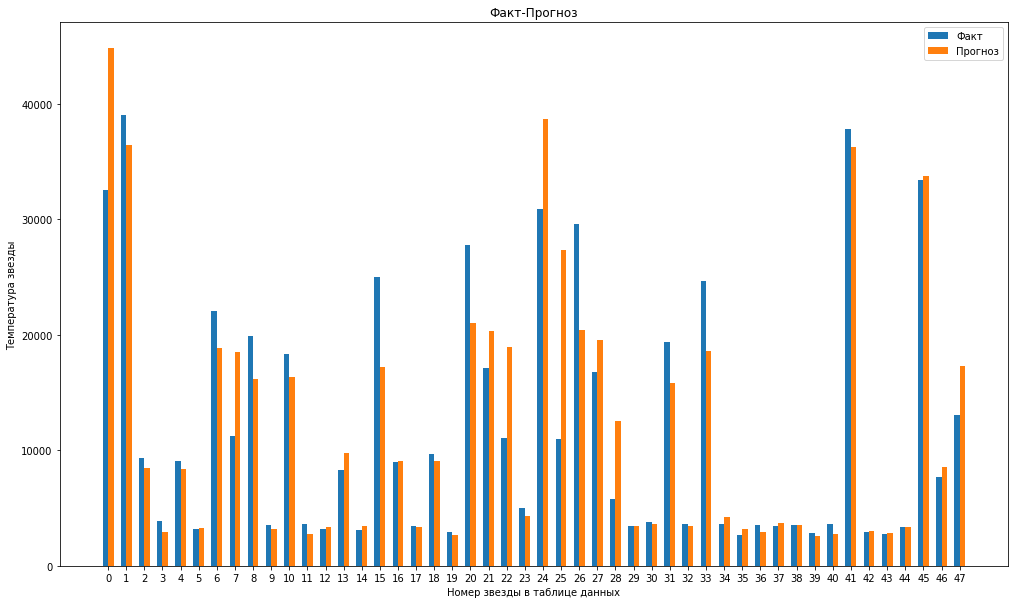

In [57]:
vizualization(target_test, test_preds)

**Вывод:**

Нейросеть хорошо предсказывает температуру звёзд до 10000 градусов. Тажке мы нашли лучшую на данный момент метрику, а именно Adam с шагом сходимости в 0.01

## Улучшение нейронной сети

Для улучшения работы нейронной сети мы будем использовать Dropout и BatchNorm1d. Далее, мы будем проверять, смогут ли данные методы улучшить работу нейронной сети.

In [58]:
class Model(nn.Module):
    def __init__(self, n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_out_neurons):
        super(Model, self).__init__()
        
        self.fc1 = nn.Linear(n_in_neurons, n_hidden_neurons_1)
        self.bn1 = nn.BatchNorm1d(n_hidden_neurons_1)
        self.act1 = nn.ReLU()
        self.dp2 = nn.Dropout(p=0.2)
        self.fc2 = nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2)
        self.bn2 = nn.BatchNorm1d(n_hidden_neurons_2)
        self.act2 = nn.ReLU()
        self.fc3 = nn.Linear(n_hidden_neurons_2, n_out_neurons)
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.act1(x)
        x = self.dp2(x)
        x = self.fc2(x)
        x = self.bn2(x)
        x = self.act2(x)
        x = self.fc3(x)
        
        return x

In [59]:
net = Model(n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_out_neurons)
loss = nn.MSELoss()

optimizer = torch.optim.RMSprop(net.parameters(), lr=1e-3)
optimizer1 = torch.optim.Adam(net.parameters(), lr=1e-3)
optimizer2 = torch.optim.Adam(net.parameters(), lr=1e-2)
optimizer3 = torch.optim.Adamax(net.parameters(), lr=1e-2)

In [60]:
%%time

x = [optimizer, optimizer1, optimizer2, optimizer3]

for i in x:
    print(i)
    cross_vall_score(net, features_train, target_train, i)

RMSprop (
Parameter Group 0
    alpha: 0.99
    centered: False
    eps: 1e-08
    lr: 0.001
    momentum: 0
    weight_decay: 0
)
processing fold # 1  RMSE метрика = 12433.060546875
processing fold # 2  RMSE метрика = 4178.54541015625
processing fold # 3  RMSE метрика = 6301.0048828125
processing fold # 4  RMSE метрика = 4156.5224609375
Средняя RMSE метрика = 6767 

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
)
processing fold # 1  RMSE метрика = 6226.2998046875
processing fold # 2  RMSE метрика = 2823.4501953125
processing fold # 3  RMSE метрика = 3587.384521484375
processing fold # 4  RMSE метрика = 3443.4599609375
Средняя RMSE метрика = 4020 

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.01
    weight_decay: 0
)
processing fold # 1  RMSE метрика = 3262.572021484375
processing fold # 2  RMSE метрика = 2700.56396484375
processing fold # 3  RMSE метрика = 2786.23461

In [61]:
net = neuron(net, features_train, target_train, optimizer3)

In [62]:
net.eval()
test_preds = net.forward(features_test)
print('Показатель RMSE нейронной сети на тестовой выборке:', int(torch.sqrt(loss(target_test,test_preds))))

Показатель RMSE нейронной сети на тестовой выборке: 5075


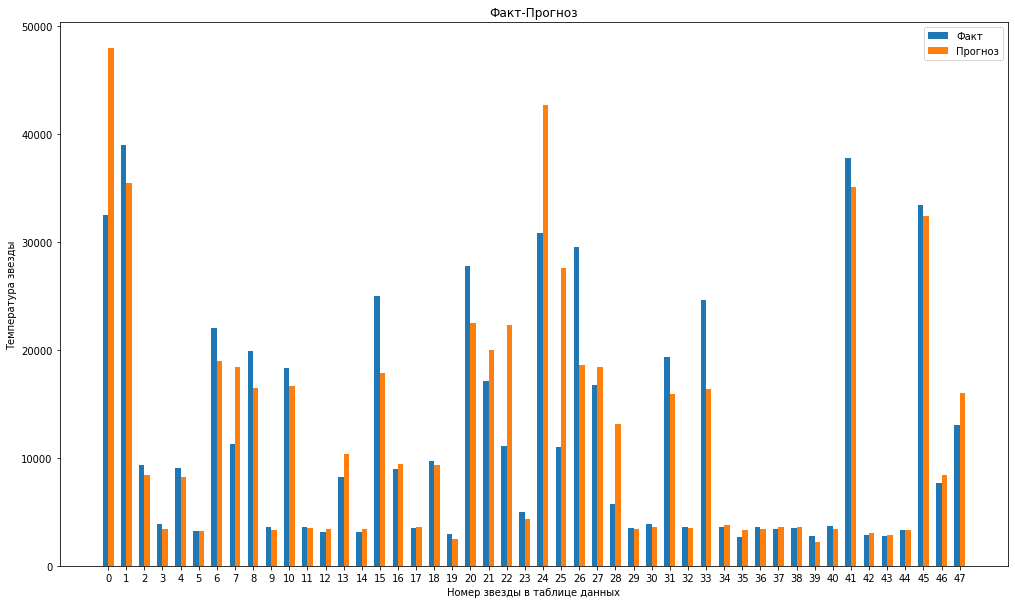

In [63]:
vizualization(target_test, test_preds)

**Вывод:**

После применения Dropoгt и BatchNorm1d мы видим, что метрика RMSE стала больше. Вместо 4475, RMSE стало 5075. Поэтому для оптимального решения задачи необходимо будет использовать первую модель.

## Выводы

В ходе проведённого исследования нами были выполнены следующие задачи:

1) Загрузили данные.

2) Провели предоработку данных, где вВыяснили, что пропусков и дубликатов нет, перевели название столбцов в соответствующий вид убрав верхний регистр, а также лишние дефисы и пропуски, перевели категориальные данные в соответствующий вид, сократили число категорий звёзд путём их укрупнения, а также разделили выборки для дальнейшего исследования и перекодировали их, и также перевели данные в torch.

3) В ходе построения баозовой нейронной сети мы выяснили, что она хорошо предсказывает температуру звёзд до 10000 градусов. Также мы нашли лучшую на данный момент метрику, а именно Adam с шагом сходимости в 0.01

4) В ходе улучшения модели мы применили методы  Dropout и BatchNorm1d, которые повысили значение RMSE. Поэтому для оптимального решения задачи необходимо будет использовать первую модель.